**Table of contents**<a id='toc0_'></a>    
- 1. [Asymmetry and Periodicity Metrics](#toc1_)    
  - 1.1. [Light-Curve](#toc1_1_)    
- 2. [M- index: Asymmetry](#toc2_)    
- 3. [Q-index: Periodicity](#toc3_)    
- 4. [Filtering](#toc4_)    
  - 4.1. [Pre-selection of variables:](#toc4_1_)    
  - 4.2. [General](#toc4_2_)    
  - 4.3. [For M-index](#toc4_3_)    
  - 4.4. [For Q-index](#toc4_4_)    
- 5. [Period Search and Aperiodic Timescales](#toc5_)    
- 6. [General notes:](#toc6_)    
- 7. [flux vs mag](#toc7_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

# 1. <a id='toc1_'></a>[Asymmetry and Periodicity Metrics](#toc0_)

Last update: 19 Jan 2024

**@juliaroquette:** This notebook concentrates research-notes related to the implementation of a Python code for calculating Asymmetry and Periodicity indexes. These variability-indexes have been first introduced by [Cody+2014](https://iopscience.iop.org/article/10.1088/0004-6256/147/4/82) and are used to quantify the degree of symmetry/asymmetry and of stochasticity/periodicity in light-curves of Young Stellar Objects (YSOs). Once calculated for a given light-curve, these indexes can be used to place the star in a QM-diagram (see figure below), threshold of the two indexes can be used for classification purposes and certain regions of the diagram can be associated to physical mechanisms behind the variability processes being observed. The two indexes can also be used as feature in Machine-Learning applications. 

![QM-space](https://content.cld.iop.org/journals/1538-3881/147/4/82/revision1/aj492147f8_lr.jpg?Expires=1706211409&Signature=ANR2FKG9Mg75LFi2fPfpVfgdKx~z8PajoShKj1l2AKeQaS7K1f2u3SWXaGa4LqunH6og1RjPtGO2lkWOexBJAJEiG64j0h4wd~ixyYf4Nr8VwQk9l9DquV~T277Ff99jEl87zgYt4EXKxq3c5OINEYj99cAAlSblw63r7gNldAk9YQfN3Pb5rOvuKHUYMaksjOP4g3t5ng2UYMFf5R7-McYdvieaI03opfv0aillqBaJ1uSQUjXZGnxbci11Y32e8YdPKemi3PETyYhNtBSFesHEfMU889heezzxGduj44fxEBpEa3dt1ishRlUjaw2tdH7XTJSc2E6VBbZDxNJShw__&Key-Pair-Id=KL1D8TIY3N7T8)


**References:** 

Main previous studies applying the metrics to large samples of YSOs:
- `C14`: [Cody+2014](https://iopscience.iop.org/article/10.1088/0004-6256/147/4/82)
- `C18`: [Cody+2018](https://iopscience.iop.org/article/10.3847/1538-3881/aacead)
- `B20`: [Bredall+2020](https://doi.org/10.1093%2Fmnras%2Fstaa1588)
- `C22`: [Cody+2022](https://iopscience.iop.org/article/10.3847/1538-3881/ac5b73)
- `H22`: [Hillenbrand+2022](https://iopscience.iop.org/article/10.3847/1538-3881/ac62d8)

## 1.1. <a id='toc1_1_'></a>[Light-Curve](#toc0_)

A light-curve is written as a series of measurements $m$ with uncertainties $\sigma$ as a function of time, $t$:

- $m_i$ and $\sigma_i$ are magnitudes and their uncertainties at the time $t_i$. 
- Alternatively the light-curve can be written in terms of fluxes $f_i$ and their uncertainties. 

In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
from astropy.convolution import Box1DKernel, convolve

Basic function to fold light-curves in phase:

In [2]:
def fold(time, mag, period):
    """
    Folds the light curve in phase for a given period. 
    Returns magnitudes sorted by phase.

    Parameters:
    - mag: array-like, magnitudes (or uncertainties) of the light curve
    - time: array-like, time values of the light curve
    - period: float, period of the light curve

    Returns:
    - phase: array-like, phase values of the folded light curve
    - mag_sorted: array-like, magnitudes of the folded light curve sorted by phase
    
    """
    # Calculate the phase values
    phase = np.mod(time, period) / period
    
    # Sort the phase and magnitude arrays based on phase values
    sort = np.argsort(phase)
    phase = phase[sort]
    mag_sorted = mag[sort]
    
    return phase, mag_sorted


Create a base time-axis for synthetic light-curves:

In [3]:
N = 200
time = np.linspace(0, 80, N)
err =  0.01*np.random.random_sample(N)

1. Make a purely periodic light-curve:

Text(0, 0.5, 'magnitude')

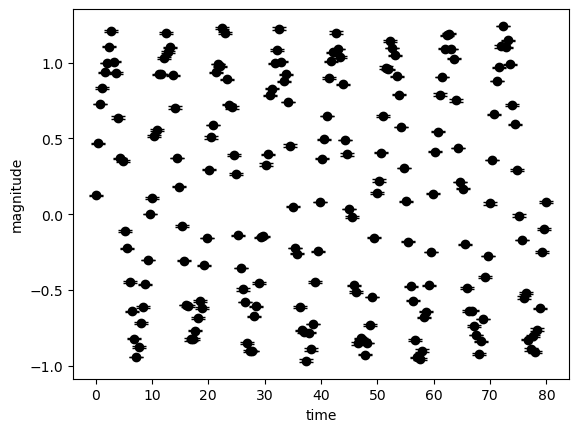

In [4]:
period = 10. 
mag_sin = np.sin(2*np.pi*time/period) + np.random.random_sample(N)*.25
plt.errorbar(time, mag_sin, err, fmt='o', color='black', capsize=5)
plt.xlabel('time')
plt.ylabel('magnitude')

Text(0, 0.5, 'magnitude')

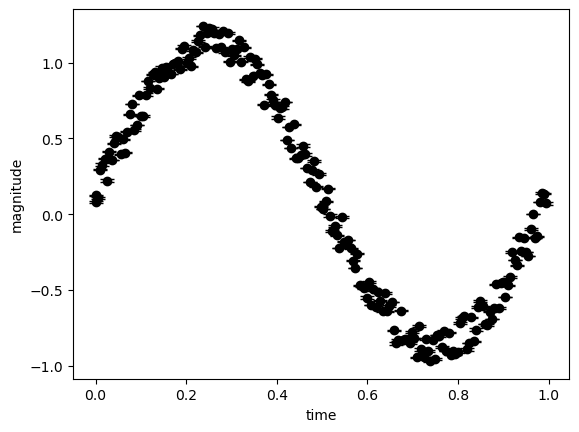

In [5]:
phase_sin, mag_sorted_sin = fold(time, mag_sin, period)
_, err_mag_phased_sin = fold(time, err, period)
plt.errorbar(phase_sin, mag_sorted_sin, err_mag_phased_sin, fmt='o', color='black', capsize=5)
plt.xlabel('time')
plt.ylabel('magnitude')

2. Make a strictly periodic eclipse-like light-curve:

Text(0, 0.5, 'magnitude')

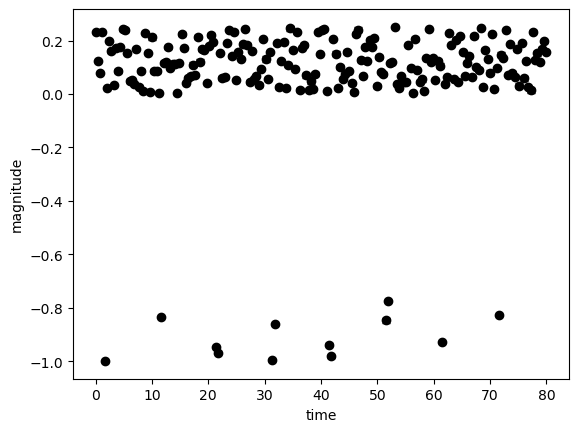

In [6]:
mag_eclipse = np.random.random_sample(N)*.25
period_eclipse = 4.  # Period of the waveform
eclipse_start = 0.3  # Start time of the eclipse
eclipse_end = 0.9  # End time of the eclipse
eclipse_depth = 1.  # Depth of the eclipse (0.0 to 1.0)
n = 2.*np.random.random(1) # get a random phase
while n < max(time):
    eclipse_mask = np.logical_and(time >= n + eclipse_start  , time <= n+ eclipse_end)
    mag_eclipse[eclipse_mask] -= eclipse_depth
    n += period
plt.errorbar(time, mag_eclipse, err, fmt='o', color='black', capsize=3)
plt.xlabel('time')
plt.ylabel('magnitude')

Text(0, 0.5, 'magnitude')

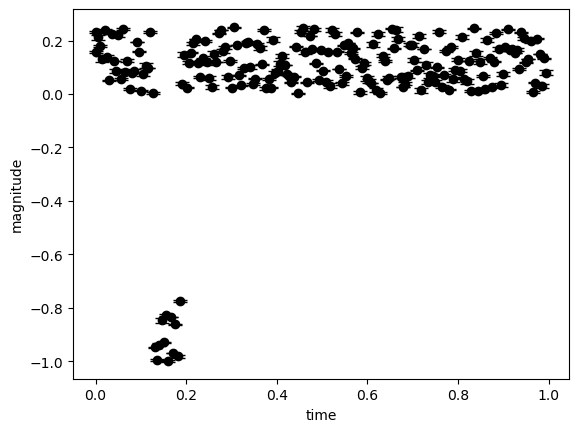

In [7]:
phase_ec, mag_sorted_ec = fold(time, mag_eclipse, period)
phase_ec, err_mag_phased_ec = fold(time, err, period)
plt.errorbar(phase_sin, mag_sorted_ec, err_mag_phased_ec, fmt='o', color='black', capsize=5)
plt.xlabel('time')
plt.ylabel('magnitude')

3. Quasi-periodic light curve

Quasi periodic refers to light curves whose amplitude is a function of time. Our model draws a random amplitude from a Gaussian distribution at each time step.

In [8]:
def quasi_per_amp(time, std, amp = 1, frequency = 1/10):
    '''
    Generates a lc with amplitude changing over time. For each time step, the amplitude is drawn from a Gaussian distribution

    Args :
        time : light curve time array
        std : std of Gaussian

    returns :
        mag
    '''

        
    random_steps     = np.random.normal(0, std, len(time))            
    amp_t            = np.cumsum(random_steps) + amp
    mag_qp           = amp_t * np.sin(2 * np.pi * frequency * (time - min(time))) + \
                       np.random.normal(0, 0.05, len(time))

    return mag_qp

Text(0, 0.5, 'magnitude')

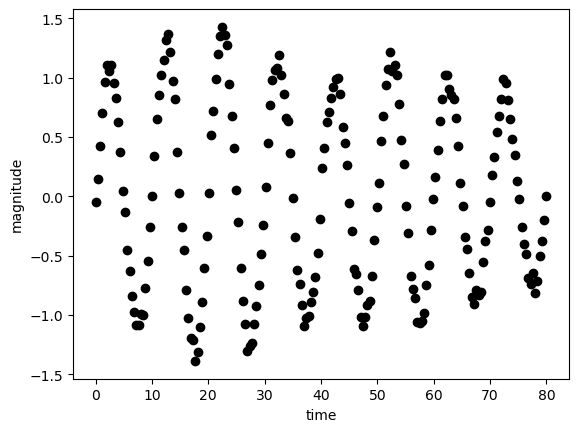

In [9]:
mag_qp = quasi_per_amp(time, 0.03, frequency = 1/period)

plt.errorbar(time, mag_qp, err, fmt='o', color='black', capsize=3)
plt.xlabel('time')
plt.ylabel('magnitude')

Text(0, 0.5, 'magnitude')

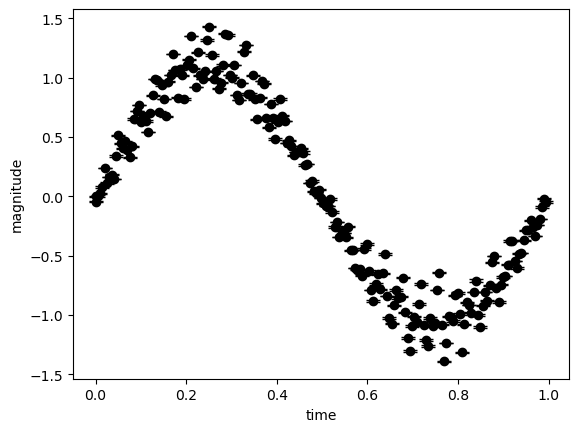

In [10]:
phase_qp, mag_sorted_qp = fold(time, mag_qp, period)
_, err_mag_phased_qp    = fold(time, err, period)
plt.errorbar(phase_qp, mag_sorted_qp, err_mag_phased_qp, fmt='o', color='black', capsize=5)
plt.xlabel('time')
plt.ylabel('magnitude')

4. Quasi periodic burst



In [11]:
def qp_burst(time, std, amp=1, frequency=1/10, burst_factor=2):
    '''
    Generates a quasi periodic burst light curve with amplitude changing over time.
    Amplitude is higher on the upper part of the sine (bursts).

    Args:
        std: std of Gaussian for overall amplitude variation
        amp, frequency : parameters of the sine
        burst_factor: factor controlling burstiness (higher values result in stronger bursts)

    Returns:
        mag_qpb
    '''

    # Calculate cumulative amplitude with burstiness
    random_steps = np.random.normal(0, std, len(time))
    amp_t = np.cumsum(random_steps) + amp
    amp_t_burst = amp_t + burst_factor * 0.5 * (1 + np.sin(2 * np.pi * frequency * (time - min(time))))

    # Generate quasi-periodic burst light curve
    mag_qpb = amp_t_burst * np.sin(2 * np.pi * frequency * (time - min(time))) + \
                   np.random.normal(0, 0.05, len(time))

    return mag_qpb

Text(0, 0.5, 'magnitude')

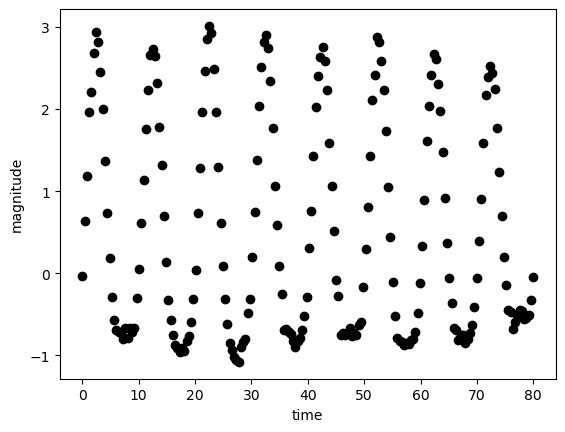

In [12]:
mag_qpb = qp_burst(time, 0.03, frequency = 1/period)

plt.errorbar(time, mag_qpb, err, fmt='o', color='black', capsize=3)
plt.xlabel('time')
plt.ylabel('magnitude')

Text(0, 0.5, 'magnitude')

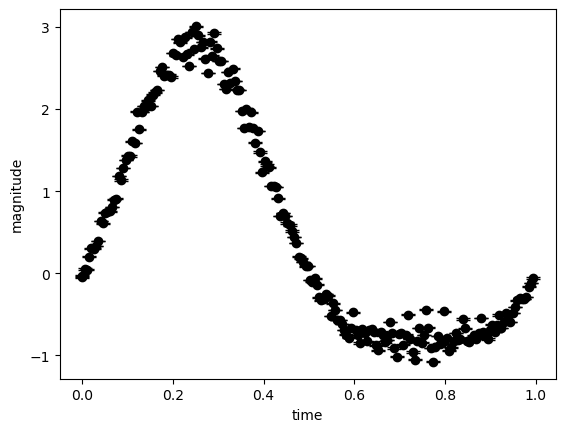

In [13]:
phase_qpb, mag_sorted_qpb = fold(time, mag_qpb, period)
_, err_mag_phased_qpb    = fold(time, err, period)
plt.errorbar(phase_qpb, mag_sorted_qpb, err_mag_phased_qpb, fmt='o', color='black', capsize=5)
plt.xlabel('time')
plt.ylabel('magnitude')

5. Aperiodic burst

Aperiodic light curves modelled with a random walk. Bursts are added via Gaussian peaks

In [14]:
def apb(time, num_bursts, burst_depth_range, burst_width_range, amp = 1):
        """
        Generate a synthetic light curve with aperiodic bursts. Amplitude of the curve is based on self.amp
        Based on a random walk.
        """
    
        rand_walk = np.cumsum(np.random.randn(len(time)))

        for _ in range(num_bursts):
            burst_position = np.random.randint(0, len(time))
            burst_depth    = np.random.uniform(*burst_depth_range)
            burst_width    = np.random.uniform(*burst_width_range)

            gaussian_peak = burst_depth * np.exp(-((time - burst_position) / (burst_width / 2))**2)
            rand_walk    -= gaussian_peak

        # Normalize rand_walk to have a peak-to-peak amplitude of 1
        normalized_rand_walk = (rand_walk - np.min(rand_walk)) / (np.max(rand_walk) - np.min(rand_walk))

        # Scale with self.amp and add self.med_mag
        mag_apb = normalized_rand_walk * amp
        
        return mag_apb

Text(0, 0.5, 'magnitude')

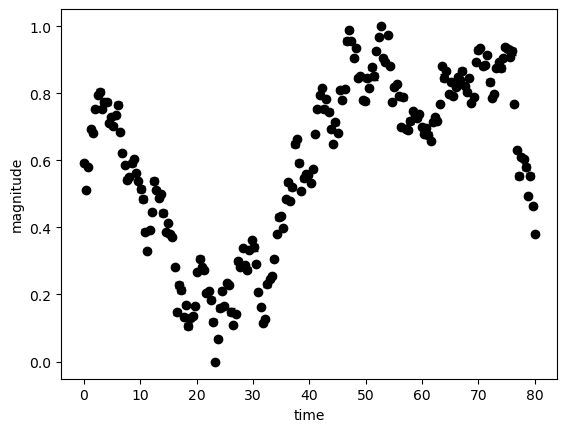

In [16]:
bursts          = 3
depth_range   = (0.3, 1)
width_range   = (0.5, 2.5)
mag_apb = apb(time, bursts, depth_range, width_range)

plt.errorbar(time, mag_apb, err, fmt='o', color='black', capsize=3)
plt.xlabel('time')
plt.ylabel('magnitude')

6. Quasi-periodic dipper

In [17]:
def qp_dips(time, std, amp=1, frequency=1/10, dip_factor=2):
    '''
    Generates a quasi periodic dips light curve with amplitude changing over time.
    Amplitude is lower on the lower part of the sine wave (dips).

    Args:
        std: std of Gaussian for overall amplitude variation
        amp, frequency : parameters of the sine
        dip_factor: factor controlling dipiness (higher values result in stronger dips)

    Returns:
        mag_qpd
    '''

    # Calculate cumulative amplitude with dips
    random_steps = np.random.normal(0, std, len(time))
    amp_t = np.cumsum(random_steps) + amp
    dipiness = dip_factor * 0.5 * (1 - np.sin(2 * np.pi * frequency * (time - min(time))))
    amp_t_dips = amp_t * (1 + dipiness)

    # Generate quasi-periodic dips light curve
    mag_qpd = amp_t_dips * np.sin(2 * np.pi * frequency * (time - min(time))) + \
                   np.random.normal(0, 0.05, len(time))

    return mag_qpd


Text(0, 0.5, 'magnitude')

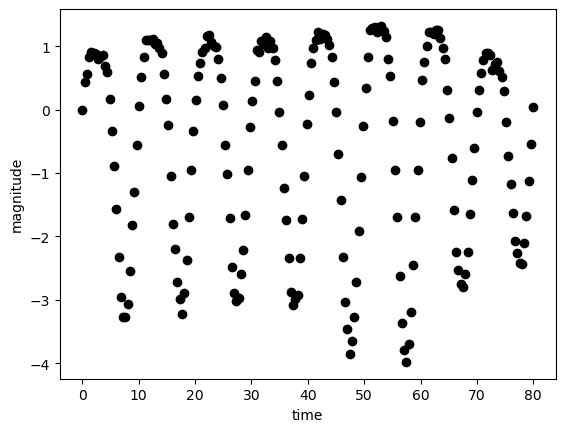

In [18]:
mag_qpd = qp_dips(time, 0.03, frequency = 1/period, dip_factor = 2)

plt.errorbar(time, mag_qpd, err, fmt='o', color='black', capsize=3)
plt.xlabel('time')
plt.ylabel('magnitude')

Text(0, 0.5, 'magnitude')

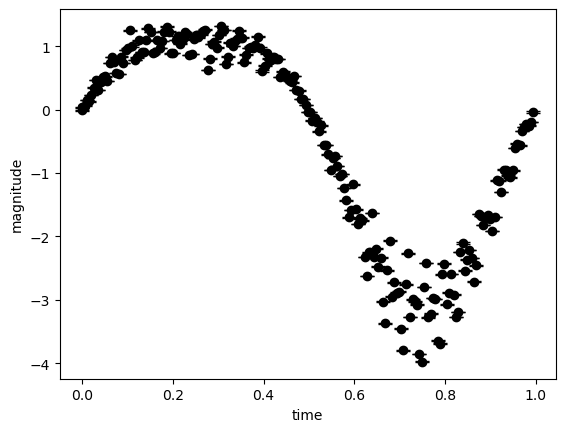

In [19]:
phase_qpd, mag_sorted_qpd = fold(time, mag_qpd, period)
_, err_mag_phased_qpd    = fold(time, err, period)
plt.errorbar(phase_qpd, mag_sorted_qpd, err_mag_phased_qpd, fmt='o', color='black', capsize=5)
plt.xlabel('time')
plt.ylabel('magnitude')

7. Aperiodic  dipper

In [20]:
def apd(time, num_dips, dip_depth_range, dip_width_range, amp = 1):
        """
        Generate a synthetic light curve with aperiodic dips. Amplitude of the curve is based on self.amp
        Based on a random walk.
        """
    
        rand_walk = np.cumsum(np.random.randn(len(time)))

        for _ in range(num_dips):
            dip_position = np.random.randint(0, len(time))
            dip_depth    = np.random.uniform(*dip_depth_range)
            dip_width    = np.random.uniform(*dip_width_range)

            gaussian_peak = dip_depth * np.exp(-((time - dip_position) / (dip_width / 2))**2)
            rand_walk    -= gaussian_peak

        # Normalize rand_walk to have a peak-to-peak amplitude of 1
        normalized_rand_walk = (rand_walk - np.min(rand_walk)) / (np.max(rand_walk) - np.min(rand_walk))

        # Scale with self.amp and add self.med_mag
        mag_apd = normalized_rand_walk * amp
        
        return mag_apd

Text(0, 0.5, 'magnitude')

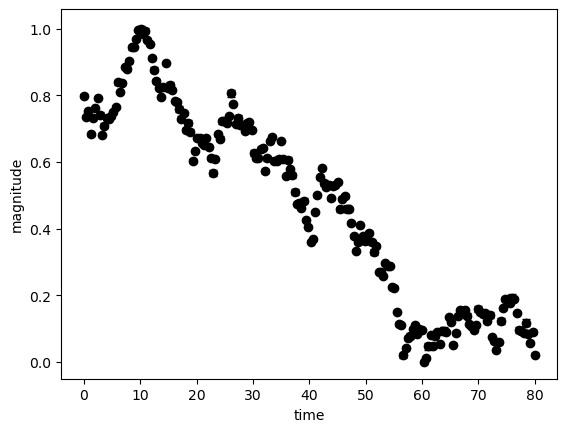

In [21]:
dips          = 3
depth_range   = (0.3, 1)
width_range   = (0.5, 2.5)

mag_apd = apd(time, dips, depth_range, width_range)
plt.errorbar(time, mag_apd, err, fmt='o', color='black', capsize=3)
plt.xlabel('time')
plt.ylabel('magnitude')

Text(0, 0.5, 'magnitude')

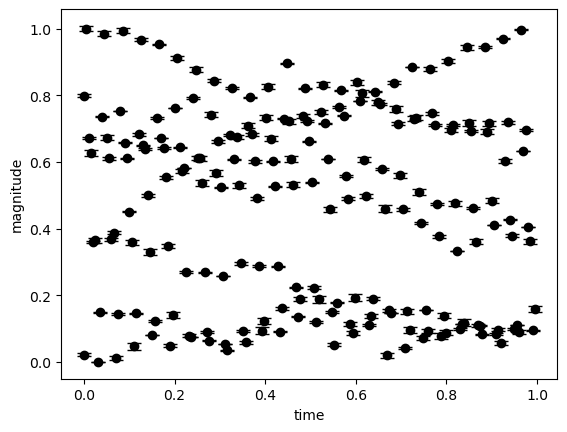

In [22]:
phase_apd, mag_sorted_apd = fold(time, mag_apd, period)
_, err_mag_phased_apd     = fold(time, err, period)
plt.errorbar(phase_apd, mag_sorted_apd, err_mag_phased_apd, fmt='o', color='black', capsize=5)
plt.xlabel('time')
plt.ylabel('magnitude')

8. Multiperiodic

Light curves with a primary period around 5-10 days, and a longer secondary period around 20-40 days

In [23]:
def multiperiodic(time, frequency = 1/5, frequency_long = 1/40, amp = 1, amp2 = 0.2):
        noise             = np.random.normal(0, 0.03, len(time))
        mag_mp            = amp * np.sin(2 * np.pi * frequency * (time - min(time))) + \
                            amp2 * np.sin(2 * np.pi * frequency_long * (time - min(time))) + \
                            noise
        return mag_mp

Text(0, 0.5, 'magnitude')

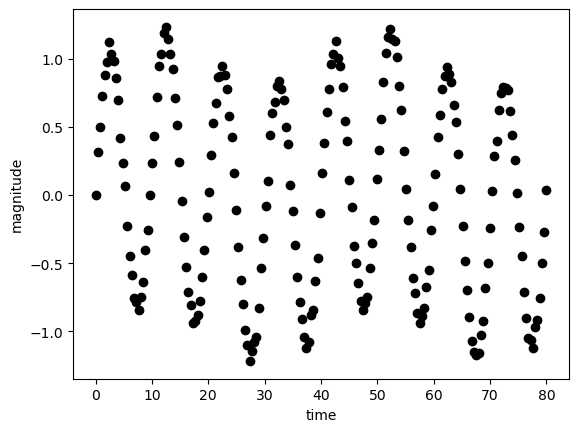

In [24]:
mag_mp = multiperiodic(time, frequency = 1/period)
plt.errorbar(time, mag_mp, err, fmt='o', color='black', capsize=3)
plt.xlabel('time')
plt.ylabel('magnitude')

Text(0, 0.5, 'magnitude')

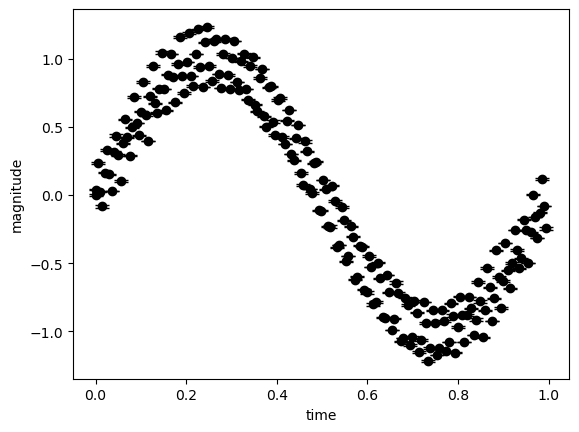

In [25]:
phase_mp, mag_sorted_mp = fold(time, mag_mp, period)
_, err_mag_phased_mp    = fold(time, err, period)
plt.errorbar(phase_mp, mag_sorted_mp, err_mag_phased_mp, fmt='o', color='black', capsize=5)
plt.xlabel('time')
plt.ylabel('magnitude')

## 2. <a id='toc2_'></a>[M- index: Asymmetry](#toc0_)

**Context**: Metrics that measures the level of assymetry in the light-curve.

$$M=\frac{<m_{10\%}>-m_{med}}{\sigma_m}$$

where:
- $<m_{10\%}>$ is all the data in the top and bottom decile of the light-curve. 
- $\sigma_m$ is the light-curve's standard deviation

This definition sets predominantly brightening light-curves with $M < 0$ and predominantly dimming  with $M > 0$.

When using fluxes, one must add a $-1\times$ to $M$'s definition to preserve the dimming/brightening signal definition. 

**Note on filtering**: Light-curves must be appropriately pre-filtered. See section on this subject ([Filtering](#filtering)). 

**Literature definition variations**

- $\sigma_m$ is sometimes the overall rms (`C14`) of the light-curve and sometimes its standard-deviation (`H22`, `B20`).
- Use of deciles: `C18` reports the use of 5/95 percentiles rather than deciles. However, Ann Marie Cody told us in private communication that this might be a typo in the paper as her code `C22` is using 10/90. 

In [26]:
def M_index(mag, per_up=90., per_down=10., is_flux=False):
    """
    Calculate the M-index, which measures the level of asymmetry in the light-curve.
    
    Parameters:
    - mag: array-like, magnitudes of the light-curve
    - per_up: float, upper percentile for selecting data in the top decile
    - per_down: float, lower percentile for selecting data in the bottom decile
    - is_flux: bool, indicates whether the input is flux or magnitude
    
    Returns:
    - M-index: float, the calculated M-index value
    
    """
    if bool(is_flux):
        to_flux = -1
    else:
        to_flux = 1
    return to_flux*(np.mean(mag[(mag <= np.percentile(mag, per_down)) | (mag >= np.percentile(mag, per_up))]) - np.median(mag))/np.std(mag)

In [27]:
print("Sinusoidal M-index: ", M_index(mag_sorted_sin))
print("Eclipse M-index: ", M_index(mag_sorted_ec))

Sinusoidal M-index:  -0.0003028248023289338
Eclipse M-index:  -1.0471889381852229


## 3. <a id='toc3_'></a>[Q-index: Periodicity](#toc0_)

**Context**: Metrics that measures the degree of periodicity in the light-curve. 

$Q = \frac{\sigma_\mathrm{res}^2-\sigma_\mathrm{phot}^2}{\sigma^2_\mathrm{raw}-\sigma^2_\mathrm{phot}}$, 

where:
- $\sigma_\mathrm{res}^2$ and $\sigma^2_\mathrm{raw}$ are the variance values of the raw light curve and the phase-subtracted light curve.
- $\sigma_\mathrm{raw}^2$ is the variance of the original light-curve
- $\sigma_\mathrm{phot}$ is the mean photometric error

In [28]:
def Q_index(mag_phased, residual_mag, err_phased):
        """
        Calculates the Q-index which measures the level of periodicity in the light-curve.

        Parameters:
        mag_phased (array-like): Array of phase-folded magnitudes for the "raw" light-curve.
        residual_mag (array-like): Array of phase-folded residual magnitudes after waveform-subtraction
        err_phased (array-like): Array of errors for the phase-folded light-curve.

        Returns:
        - Q-index float: The calculated Q-index.

        """
        return (np.std(residual_mag)**2 - np.mean(err_phased)**2)/(np.std(mag_phased)**2 - np.mean(err_phased)**2)

Before plugging-in values in Q, a few extra steps are required:

1. Definition of $m_{raw}$: This is the original "raw" light-curve. This light-curve is called raw, but it has been already filtered for any needs deemed necessary by authors as pre-filtering before a period-search technique is applied. There is a lot of variation in what this filtering entails, hence see Filtering section below. Typical filtering will include $5-\sigma$-clipping and de-trending for variability at longer timescales than resolved by the light-curve. For high-cadence light-curves filtering may also include a short-timescale filtering that helps focusing the period-search step.
2. $\sigma_\mathrm{raw}^2$ is the variance of the light-curve in 1. 
3. $\sigma_\mathrm{phot}$ is the typical photometric error in the light-curve. In general, this is a simple average of the uncertainties in the light-curve, considering the $\sigma_i$s of all datapoints left in the filtered light-curve in step 1. However, a few studies derive a typical uncertainty value by looking at rms vs magnitude distributions for samples of less-variable stars in their survey (`C14`, `C18`, `C22`). This seems to be more common for CoRoT and K2 data though. 
4. Residual light-curve: This is the most important step for calculating Q. 

    4.1 A period-search technique is applied to $m_{raw}$ to find the dominant period, P. When no period is found, a "aperiodic timescale" must be defined instead. (see further discussion in the session below.)

    4.2 $m_{raw}$ is phase-folded to this period or timescale and some filtering is used to estimate a phase-folded waveform. (See Waveform estimation Section below)

    4.3 A residual light-curve, $m_{res}$ is defined by subtracting the waveform from the folded $m_{raw}$. A few authors do this by repeating the waveform over the length of the light-curve, but I don't think it makes a difference in the final $\sigma_\mathrm{res}$ to estimate it from the folded or from the regular light-curve. 

    4.4 $\sigma_\mathrm{res}$ is calculated from the residual light-curve ($m_{res}$)

## Deriving the Waveform:

1. Rolling Average as a function of number of data points
2. Rolling Average as a function of phase
3. `H22` & `B20` method: boxcar window of width 25% of the period (smoothing the light curve by a factor of 4). 
4. `C22` smoothed the phase-folded light curve with a window of 5%.


In [26]:
int(3.2), np.round(3.5), np.floor(3.2), np.ceil(3.2), np.trunc(3.2)

(3, 4.0, 3.0, 4.0, 3.0)

In [65]:
def rolling_average_waveform(mag_phased, window_size=5):
    """
    Calculates the rolling average while centering the data around the phase value.
    
    Parameters:
        mag_phased (array-like): Array of phased data.
        window_size (int): Size of the rolling window in number of datapoints. Default is 5.
        
    Returns:
        waveform (array-like): Array with the waveform .
        
    Assumes phased data is circular.
    """
    extended_mag = np.concatenate((mag_phased, mag_phased, mag_phased))
    waveform = np.array([np.mean(extended_mag[i-int(0.5*window_size):i+int(np.round((0.5*window_size)))]) 
                         for i in np.arange(int(0.5*window_size),len(extended_mag)-
                                            int(np.round(0.5*window_size+1)))])[
                                                len(mag_phased)-int(0.5*window_size):
                                                    2*len(mag_phased)-int(0.5*window_size)
                        ]
    return waveform

In [66]:
def waveform_phase_fraction(phase, mag_phased, wd_phase=0.1):
    """
    Calculate the waveform phase fraction.

    Parameters:
    - phase (array-like): Array of phase values.
    - mag_phased (array-like): Array of magnitude values.
    - wd_phase (float, optional): Width of the phase window in % of phase. Default is 0.1.

    Returns:
    - waveform (array-like): Array with the waveform .
    """
    waveform = np.full(len(phase), np.nan)
    extended_phase = np.concatenate((phase - 1, phase, 1 + phase))
    extended_mag = np.concatenate((mag_phased, mag_phased, mag_phased))
    for i, p in enumerate(phase[3:]):
        select = np.where((extended_phase <= p + wd_phase/2.) & (extended_phase > p - wd_phase/2.))[0]
        waveform[i] = np.nanmean(extended_mag[select])
    return waveform

In [67]:
def waveform_H22(mag_phased, kernel=4):
    """
    Code used in Hillenbrand et al. 2022:
    Source: https://github.com/HarritonResearchLab/NAPYSOs
    """
    # Create the residual curve

    # We use three periods and extract the middle to prevent edge effects
    three_periods = np.concatenate((mag_phased, mag_phased, mag_phased))
    boxcar = Box1DKernel(len(mag_phased) // kernel)
    smooth_mag = convolve(three_periods, boxcar)
    smooth_mag = smooth_mag[np.size(mag_phased):2*np.size(mag_phased)]
    return smooth_mag

In [68]:
def waveform_Cody(mag_phased, n_point=50):
    sp.ndimage.filters.median_filter(mag_phased,size=n_point,mode='wrap')

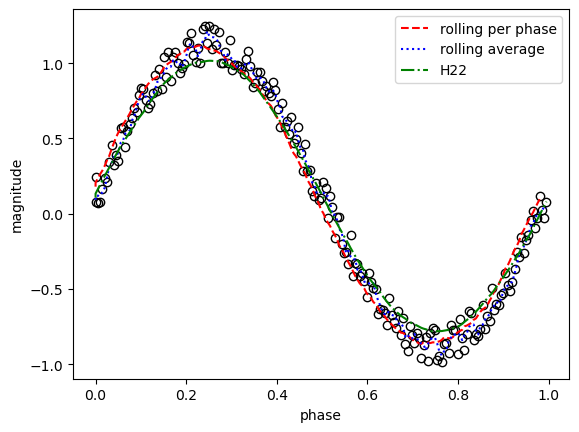

In [31]:
plt.plot(phase_sin, mag_sorted_sin, 'ko', fillstyle='none')
plt.plot(phase_sin, waveform_phase_fraction(phase_sin, mag_sorted_sin), 'r--', fillstyle='none', label='rolling per phase')
plt.plot(phase_sin, rolling_average_waveform(mag_sorted_sin), 'b:', fillstyle='none', zorder=10, label='rolling average')
plt.plot(phase_sin, waveform_H22(mag_sorted_sin), 'g-.', fillstyle='none', zorder=10, label='H22')
plt.xlabel('phase')
plt.ylabel('magnitude')
plt.legend()

Waveform can be estimated with different smoothing methods :

- Rolling average
- Median filter
- Savitsky Golay filter

The choice of the method should not be so decisive when the considered light curve is periodic. However, multiperiodic and aperiodic lightcurves are more complex to interpolate correctly.

Efficiently filtering the light curve before will improve the waveform estimation for multiperiodic light curves (see Filtering section).

The window size is also a decisive parameter : if the window is too wide, distinctive features of the curve disappear, but narrow windows might lead to overfitting. 

In [29]:
from   scipy.signal import medfilt

length       = len(time)
window_sizes = [int(0.055 * length), int(0.205 * length)]

types = ['mp', 'apd', 'qpd']

for it, window in enumerate(window_sizes):
    for type_lc in types :
        phase, mag_phased = locals()[f'phase_{type_lc}'], locals()[f'mag_sorted_{type_lc}']
        
        # rolling average
        mag_roll   = pd.Series(mag_phased).rolling(window, min_periods=window, win_type='boxcar', center=True, closed='neither').mean()
        locals()[f'mag_roll_{window}_{type_lc}']   = mag_roll.dropna().values  # Remove NaN values

        start_idx  = (window - 1) // 2  
        end_idx    = start_idx + len(locals()[f'mag_roll_{window}_{type_lc}'])
        locals()[f'phase_roll_{window}_{type_lc}'] = phase[start_idx:end_idx]


        # sav gol filter
        mag_sg = savgol_filter(mag_phased, window, 3)
        locals()[f'mag_sg_{window}_{type_lc}'] = mag_sg[~np.isnan(mag_sg)]  # Remove NaN values

        start_idx  = 0  
        end_idx    = start_idx + len(mag_roll)
        locals()[f'phase_sg_{window}_{type_lc}'] = phase[start_idx:end_idx]

        if len(locals()[f'mag_sg_{window}_{type_lc}']) > len(locals()[f'phase_sg_{window}_{type_lc}']) :
            mag_sg = mag_sg[0 : - (len(mag_sg) - len(phase_sg))]

        # medfilt
        if window % 2 == 0:
            window += 1
        mag_mf = medfilt(mag_phased, window)
        locals()[f'mag_mf_{window}_{type_lc}'] = mag_mf[~np.isnan(mag_mf)]  # Remove NaN values

        end_idx = start_idx + len(mag_mf)
        locals()[f'phase_mf_{window}_{type_lc}'] = phase[start_idx:end_idx]
    

NameError: name 'savgol_filter' is not defined

KeyError: 'mag_mf_11_mp'

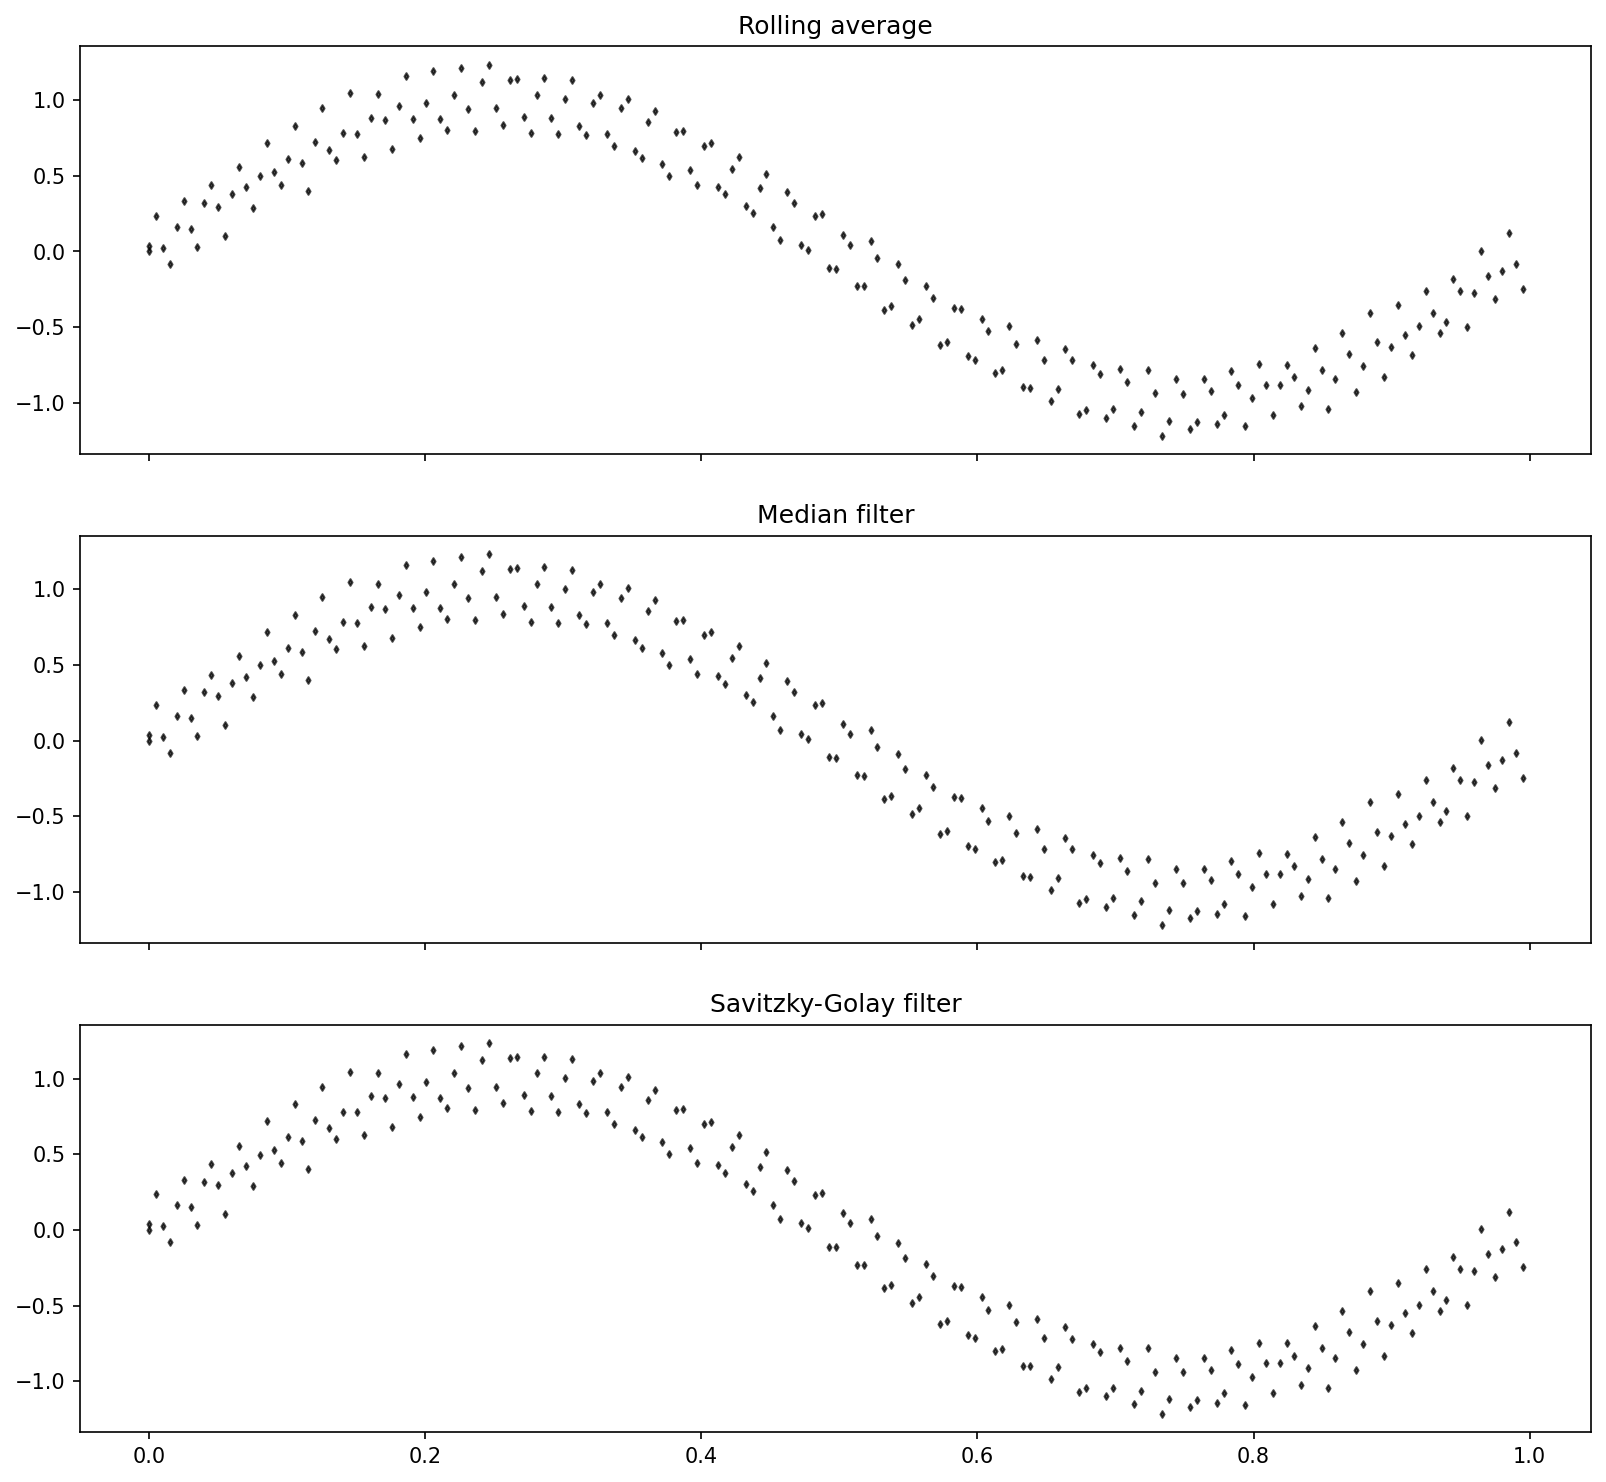

In [30]:
for type_lc in types :
    
    phase, mag_phased = locals()[f'phase_{type_lc}'], locals()[f'mag_sorted_{type_lc}']
        
    fig, axs = plt.subplots(3, 1, figsize=(13, 12), facecolor='white', dpi=150, sharex=True)
    size     = 5
    colors   = ['cornflowerblue', 'indianred']

    axs[0].scatter(phase, mag_phased, label='Original Data', c='black', marker='d', s=size, alpha = .7)
    axs[0].set_title('Rolling average')
    axs[1].scatter(phase, mag_phased, label='Original Data', c='black', marker='d', s=size, alpha = .7)
    axs[1].set_title('Median filter')
    axs[2].scatter(phase, mag_phased, label='Original Data', c='black', marker='d', s=size, alpha = .7)
    axs[2].set_title('Savitzky-Golay filter')

    length       = len(mag_phased)

    for it, window in enumerate(window_sizes):
        mag_roll   = locals()[f'mag_roll_{window}_{type_lc}']
        phase_roll = locals()[f'phase_roll_{window}_{type_lc}']
        mag_mf     = locals()[f'mag_mf_{window}_{type_lc}']
        phase_mf   = locals()[f'phase_mf_{window}_{type_lc}']
        mag_sg     = locals()[f'mag_sg_{window}_{type_lc}']
        phase_sg   = locals()[f'phase_sg_{window}_{type_lc}']

        # Plot rolling average
        axs[0].plot(phase_roll, mag_roll, label=f'window_size = {int(100*window/length)} % of datapoints', color=colors[it], lw = 3)

        # Plot Median Filter
        axs[1].plot(phase_mf, mag_mf, label=f'window_size = {int(100*window/length)} % of datapoints', color=colors[it], lw = 3)

        # Plot Savitzky-Golay Filter
        axs[2].plot(phase_sg, mag_sg, label=f'window_size = {int(100*window/length)} % of datapoints', color=colors[it], lw = 3)


    for ax in axs:
        ax.scatter(phase - 1, mag_phased, c='grey', s=7, alpha=0.2)
        ax.scatter(phase + 1, mag_phased, c='grey', s=7, alpha=0.2)
        ax.axvline(0, c = 'black', ls = '--', lw = .7)
        ax.axvline(1, c = 'black', ls = '--', lw = .7)
        ax.set_xlim(-0.5, 1.5)
        ax.invert_yaxis()
        ax.set_ylabel('Magnitude')
        ax.legend(loc='upper left')

    # Set common x-axis label
    axs[-1].set_xlabel('Phase')

# 4. <a id='toc4_'></a>[Filtering](#toc0_)
<a id='filtering'></a>


The tests carried out by @chloemas have shown us that filtering has a high impact in the obtained Q & M. 

## 4.1. <a id='toc4_1_'></a>[Pre-selection of variables:](#toc0_)
- `C14`: Stetson cross-correlation index (Stetson 1996) and pre-selection of isked sources.
- `C18`: Combined differential photometric precision (CDPP) and selection of disked sources. 
- `B20`: normalized peak-to-peak variability metric (Sokolovsky et al. 2017)
- `C22`: combined differential photometric precision (CDPP) and pre-selection of disked sources. 
- `H22`:  normalized peak-to-peak variability metric (Sokolovsky et al. 2017)


## 4.2. <a id='toc4_2_'></a>[General](#toc0_)
- `C14`: 
- `C18`: The pre-processing of K2 data includes a lot of detrending that is not fully described in the paper.
- `B20`: "remove the top and bottom 1 per cent of detections to clip potential outliers."
- `C22`: The pre-processing of K2 data includes a lot of detrending that is not fully described in the paper.
- `H22`: 


## 4.3. <a id='toc4_3_'></a>[For M-index](#toc0_)

- `C14`: 2h-timescale filtering + 5$\sigma$-clipping -> remove outliers, than go back to the un-filtered lc but without outliers. "removed trends on longer timescales than 15-20 days by subtracting out a smoothed version of the light curve before computing M."

Also: 

"In some cases, there is a clear asymmetry in the light curve, but it is superimposed on a longer timescale trend. Our asymmetry metric is only sensitive to asymmetries on timescales less than about half the light-curve duration, or 15–20 days. We therefore remove trends on longer timescales by subtracting out a smoothed version of the light curve before computing M.We find that a smoothing window of a few days is sufficient; in cases where short-term light-curve features were oversubtracted, we retain the M value computed on the raw data. These cases were identified visually comparing the raw light curve with the long-term trend overplotted. All light curves were also visually inspected to determine which value was most appropriate."



- `B20`: 
- `H22`: 


## 4.4. <a id='toc4_4_'></a>[For Q-index](#toc0_)

- `C14`: by subtracting a boxcar-smoothed version with a window of 10 days.

- `B20`: 

- `H22`: 


## Detrending

Long-term trends are removed from the light curves. Any variability occurring on timescales longer than the time series cannot be quantified with precision, and risks to interfere with smaller timescale variability.

Filtering the long trends is done by subtracting a box-car smoothed version of
the data. The original magnitude range can be restored by adding the median of
the initial magnitudes. The box-car method used was a Savitzky-Golay filter, with
a window size of 25% the time series, following the window used by `C14`. Other techniques such as rolling average,
median filter could have been used.

The detrending step can be checked on multiperiodic light curves

In [32]:
from scipy.signal import savgol_filter

def remove_longtrend(time, mag) :
        
        ws =  int(0.25*len(mag))

        mag_filt = savgol_filter(mag, ws, 3)
        mag_filt = mag - mag_filt + np.median(mag)
        return mag_filt

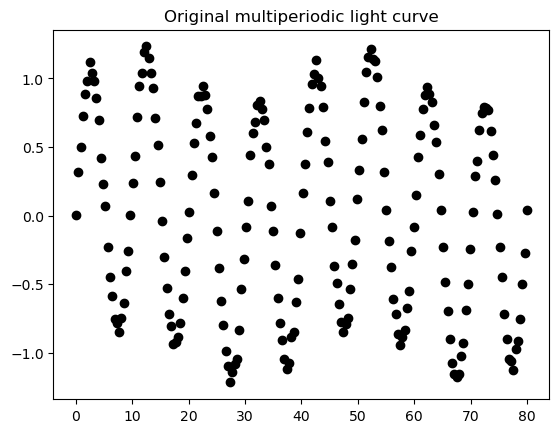

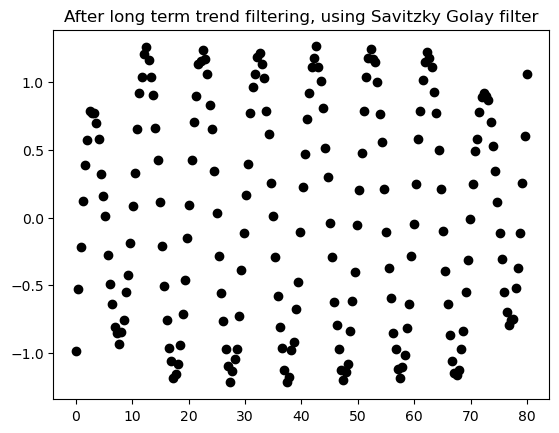

In [33]:
mag_filt = remove_longtrend(time, mag_mp)

plt.scatter(time, mag_mp,   color='black')
plt.title('Original multiperiodic light curve')
plt.show()
plt.scatter(time, mag_filt, color='black')
plt.title('After long term trend filtering, using Savitzky Golay filter')
plt.show()

After long term trends filtering, the phase folded light curve is less scattered, and the light curve should be seen as more periodic by the Q metric. 

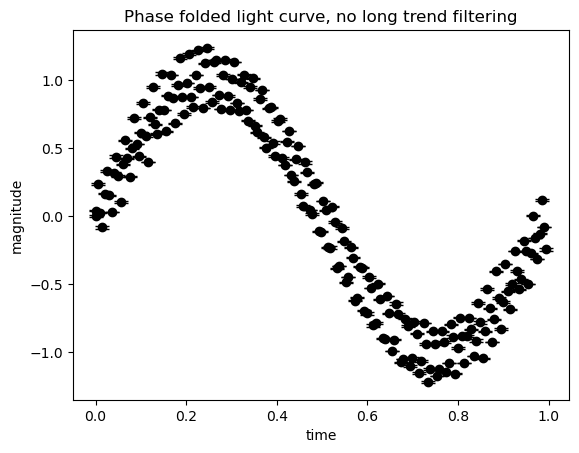

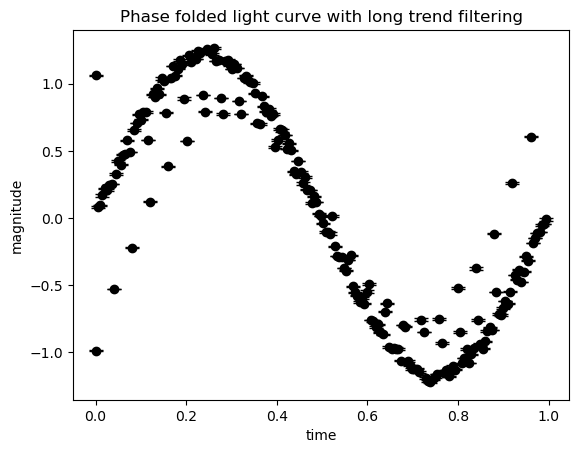

In [34]:
phase_mp_filt, mag_sorted_mp_filt = fold(time, mag_filt, period)
_, err_mag_phased_mp_filt         = fold(time, err, period)

plt.errorbar(phase_mp, mag_sorted_mp, err_mag_phased_mp, fmt='o', color='black', capsize=5)
plt.xlabel('time')
plt.ylabel('magnitude')
plt.title('Phase folded light curve, no long trend filtering')
plt.show()

plt.errorbar(phase_mp_filt, mag_sorted_mp_filt, err_mag_phased_mp, fmt='o', color='black', capsize=5)
plt.xlabel('time')
plt.ylabel('magnitude')
plt.title('Phase folded light curve with long trend filtering')
plt.show()

In [24]:
scipy.ndimage.median_filter(flux, size=715, mode='nearest')

NameError: name 'scipy' is not defined

# 5. <a id='toc5_'></a>[Period Search and Aperiodic Timescales](#toc0_)

- `C14`: ACF + FFT around ACF peak + Peak-find for aperiodic timescale
- `C18`: 
- `B20`: 
- `C22`: 
- `H22`: Lomb-Scargle (vanderplas) for both periodic and aperiodic


# 6. <a id='toc6_'></a>[General notes:](#toc0_)
 
# 7. <a id='toc7_'></a>[flux vs mag](#toc0_)
 
  There are applications using both fluxes and magnitudes on the calculation of the Q&M-indexes. Magnitudes haver the advantage of typically having a symmetric uncertainty reported, hence the 

- `C14`: magnitude
- `C18`: flux
- `B20`: magnitude
- `C22`: flux
- `H22`: magnitude